In [1]:
## Importing the libraries we will use
import numpy as np
import pandas as pd 

## Loading txt file with the cosmic ray detection rates per sec
f = open('oulu_2007_pres_corr_5min.txt', 'r')

date=[]
HCOR_E=[]

for line in f:
    line = line.strip()
    column = line.split(';')
    date.append(column[0])
    HCOR_E.append(float(column[1]))
    
f.close()

## Creating numpy array with date and cosmic ray
ar1 = np.array(HCOR_E)
ar2 = np.array(date) 

## Changing data type
x = np.asarray(ar2, dtype='datetime64[s]')


### Creating dataframe with cosmic ray and date as index
cosmic_df = pd.DataFrame({'Date': x, 'Counts/s': ar1})
cosmic_df = cosmic_df.set_index("Date")
cosmic_df.head()

,Counts/s
Date,
2007-01-01 00:00:00,107.630
2007-01-01 00:05:00,109.228
2007-01-01 00:10:00,108.519
2007-01-01 00:15:00,109.357
2007-01-01 00:20:00,109.864


In [2]:
## Finding mean for 5 days shift 
cosmic_df = cosmic_df.resample('431633S',origin = '2014-01-05 16:37:12').mean()
cosmic_df.head()

,Counts/s
Date,
2006-12-30 20:55:03,108.240171
2007-01-04 20:48:56,108.635783
2007-01-09 20:42:49,109.049201
2007-01-14 20:36:42,108.213796
2007-01-19 20:30:35,109.305850


In [3]:
## Reading data with magnitude earthquake
earthquake_df = pd.read_csv(r'magnitude.csv')
earthquake_df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2002-01-01T05:19:48.260Z,-6.366,146.819,33.0,4.8,mb,11.0,NaN,NaN,1.16,...,2014-11-07T01:14:35.137Z,"44 km NNW of Lae, Papua New Guinea",earthquake,NaN,NaN,NaN,12.0,reviewed,us,us
1,2002-01-01T08:18:27.970Z,-31.852,-67.750,10.0,4.0,ml,14.0,NaN,NaN,1.30,...,2014-11-07T01:14:35.258Z,"54 km ESE of Caucete, Argentina",earthquake,NaN,NaN,NaN,NaN,reviewed,us,guc
2,2002-01-01T09:08:54.800Z,-31.763,-67.726,10.0,4.0,md,10.0,NaN,NaN,NaN,...,2014-11-07T01:14:35.274Z,"54 km ESE of Caucete, Argentina",earthquake,NaN,NaN,NaN,NaN,reviewed,guc,guc
3,2002-01-01T09:10:54.300Z,-32.118,-177.335,33.0,4.6,mb,9.0,NaN,NaN,1.00,...,2014-11-07T01:14:35.287Z,south of the Kermadec Islands,earthquake,NaN,NaN,NaN,3.0,reviewed,us,us
4,2002-01-01T10:39:06.820Z,-55.214,-129.000,10.0,6.0,mwc,78.0,NaN,NaN,1.07,...,2022-05-02T15:40:13.614Z,Pacific-Antarctic Ridge,earthquake,NaN,NaN,NaN,NaN,reviewed,us,hrv


In [4]:
## Cleaning the time column
time = earthquake_df["time"]

lists= []
for line in time:
    line = line.split(".")
    lists.append(line[0])
    

In [5]:
## Creating data frame with earthquake magnitude and date as index 
earthquake_df = pd.DataFrame(earthquake_df, columns=[ 'mag'])
earthquake_df['Date'] = lists
earthquake_df['Date'] = pd.to_datetime(earthquake_df['Date'])
earthquake_df = earthquake_df.set_index("Date")

earthquake_df.head()

,mag
Date,
2002-01-01 05:19:48,4.8
2002-01-01 08:18:27,4.0
2002-01-01 09:08:54,4.0
2002-01-01 09:10:54,4.6
2002-01-01 10:39:06,6.0


In [6]:
## Suming magnitude in 5*0.99915 days shift
earthquake_df = earthquake_df.resample('431633S',origin = '2014-01-25 16:37:12').sum()
earthquake_df.head()

,mag
Date,
2001-12-28 10:38:13,91.90
2002-01-02 10:32:06,704.51
2002-01-07 10:25:59,574.90
2002-01-12 10:19:52,672.40
2002-01-17 10:13:45,591.80


In [7]:
## Setting date where we start calculating the pdf function
cos = cosmic_df[11:]
earthquake = earthquake_df[381:]

cos = cos.to_numpy()
earthquake = earthquake.to_numpy()

In [8]:
## Calculating pdf function for 635 5*0.99915 days shift 

import math

list_pdf = []
for i in range(635):

    ## Seeking B value 
    cos_335 = np.squeeze(cos[i:i+336])
    mean_for_median = []
    mean_cos = []

    for w in range(335) :
        mean_cos =  np.fabs([((cos_335[w+1] - cos_335[w]))])
        mean_for_median = np.concatenate((mean_for_median, mean_cos))
        
    median = np.median(mean_for_median)
    
    B_mean = []
    B_median = []
    B = []

    for c in range(335):
        B_mean = np.fabs([((cos_335[c+1] - cos_335[c]))])
        B_median = (B_mean/median) - 1 
        B = np.concatenate((B, B_median))
        
    ## Seeking A value     
    earthquake_335 = earthquake[i:i+335]
    earthquake_335_median = np.median(earthquake_335)

    A_mean = []
    A = []

    for k in range(len(earthquake_335)):
        A_mean = ((earthquake_335[k]/earthquake_335_median)-1)
        A = np.concatenate((A, A_mean))
    
    ## Calculating pdf 
    n_plus = 0
    n_minus = 0
    n = B*A
    for line in n:
        if line > 0:
            n_plus = n_plus +1
        if line != 0:
            n_minus = n_minus +1
        else: pass  

    
    pdf = (np.math.factorial(n_minus)/(np.math.factorial(n_plus)*np.math.factorial(n_minus-n_plus)))*(math.pow(0.5,n_plus)*math.pow(1-0.5,n_minus-n_plus))
    list_pdf.append(pdf)

In [9]:
## Calculating logarithm for pdf function
log_pdf = np.log10(list_pdf)


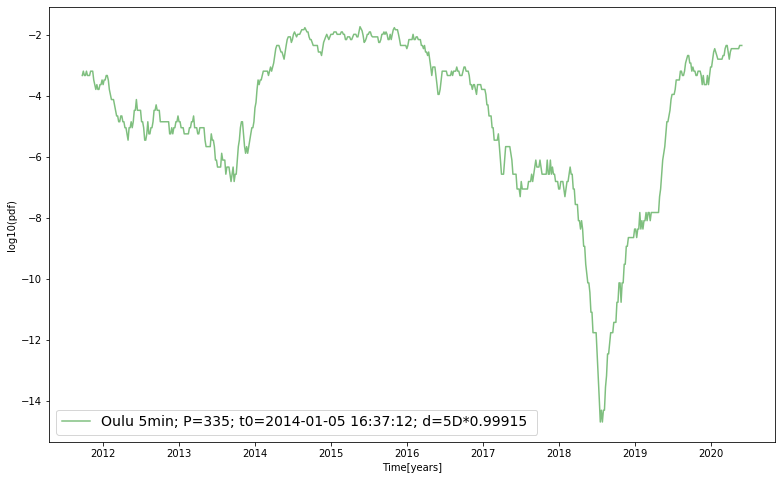

In [11]:
## Create a graph with a log pdf function on the timeline
import matplotlib.pyplot as plt
plt.plot(cosmic_df.index[11+335:11+635+335],log_pdf,label = "Oulu 5min; P=335; t0=2014-01-05 16:37:12; d=5D*0.99915 ",color='green',alpha=0.5)
plt.xlabel("Time[years]")
plt.ylabel("log10(pdf)")
plt.legend(loc="lower left",fontsize=14)
plt.rcParams['figure.figsize'] = [13, 8]
plt.show()